# Physically-based model for infiltration

In [1364]:
# python has many tools and we dont need to use all of them (it would take forever to load)
# so we have to tell python which of these modules we want to use
# import some modules that we will need for numerical calculations and for plotting
# we'll shorten their names using "as" so that we don't have to type so much
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# set up plotting so we can use special characters with latex
from matplotlib import rcParams
#rcParams['text.usetex']=True
#rcParams['text.latex.unicode']=True

# import some modules for creating the animation
from matplotlib import animation
from IPython.display import HTML

#from ipywidgets import interact, interactive, widgets
#from IPython.display import display

This is an implementation of the Richards Equation (Richards, 1931) for water infiltrating into soil in 1 dimension (vertical). The Richards equation is a partial differential equation that represents the vertical movement of water in unsaturated soils. 

Starting with the conservation equation for the changing water content with depth in a vertical column of soil (assuming no lateral flux of water, only vertical):

$$
\begin{equation}
{{d\theta}\over{dt}}=-{{dq}\over{dz}} \tag{1} \label{eq:1}
\end{equation}
$$

where the change in volumetric water content $\theta$ through time $t$ is given by the gradient in water flux $q$ with depth $z$. This states that if there is a change in the flux of water with depth ${dq}\over{dz}$ this has to be balanced by a change on the soil moisture content $\theta$. 

In [1365]:
# Let's set up some variables in python for evaluating Richard's equation:
# first we'll declare a range of depth values (cm) over which to evaluate soil moisture
# this will be like a column of data in a spreadsheet, which we'll call an "array"
MaxDepth = 100.
dz = 1.
z = np.arange(0.,MaxDepth+dz,dz)

Darcy's law can be used to describe the water flux $q$ as the product of the  hydraulic conductivity $K$ and the hydraulic gradient for saturated soil ${dH}\over{dz}$:

$$
\begin{equation}
q= -K{{dH}\over{dz}} \tag{2} \label{eq:2}
\end{equation}
$$

However, in unsaturated soil the flow of water is also governed by pressure gradients due to capillary forces in the soil wanting to suck water in to fill the pore spaces $h$. This pressure head also changes as a function of depth, so $H=h+z$ and we can rewrite equation \eqref{eq:2}:

$$
\begin{equation}
q=-K{{d(h+z)}\over{dz}} = -K\left({{dh}\over{dz}}+{{dz}\over{dz}}\right) \tag{3} \label{eq:3}
\end{equation}
$$

Since ${dz}/{dz} = 1$, we can simplify to:

$$
\begin{equation}
q=-K\left({{dh}\over{dz}}+1\right) \tag{4} \label{eq:4}
\end{equation}
$$

Substituting this into the continuity equation \eqref{eq:1}, and noting that both the hydraulic conductivity $K$ and the capilary action $h$ are themselves dependent on the moisture content $\theta$ in the soil, we get the Richards equation:

$$
\begin{equation}
{{d\theta}\over{dt}}={{d}\over{dz}} \left[ K(\theta) \left( {{dh(\theta)}\over{dz}}+1 \right) \right] \tag{5} \label{eq:5}
\end{equation}
$$

We can go further by employing the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) and defining the soil water diffusivity D(\theta):

$$
\begin{equation}
D(\theta) = K(\theta){{dh}\over{d\theta}} \tag{6} \label{eq:6}
\end{equation}
$$

such that our governing equation becomes:
$$
\begin{equation}
{{d\theta}\over{dt}}={{d}\over{dz}} \left[ D(\theta)  {{d\theta}\over{dz}}+K(\theta) \right] \tag{7} \label{eq:7}
\end{equation}
$$

In [1366]:
# To solve the Richards equation forward through time we need to define a few more terms and variables
# Since both hydrualic conductivity and capillary forces will vary with soil moisture content, we will need
# some arrays to keep track of how these values vary with depth
K = np.zeros(len(z))
h = np.zeros(len(z))

So how does pressure head vary as a function of water content? Well we would expect capillary forces to be lowest when the soil is saturated, and highest when the soil is near dry. An expression for the relationship between water content and pressure due to capillary forces $h$ can be derived by rearranging equation 3 in van Genuchten (1980) as:

$$
\begin{equation}
h={{1}\over{\alpha}} \left({{1}\over{\Theta}}-1 \right)^{1/n}  \tag{8} \label{eq:8}
\end{equation}
$$

In equation 8, $\Theta$ is the relative water content, varying between 0, corresponding to the residual water content $\theta_r$, and 1, corresponding to the saturated water content $\theta_s$:

$$
\begin{equation}
\Theta ={{\theta-\theta_r}\over{\theta_s-\theta_r}} \tag{9} \label{eq:9}
\end{equation}
$$


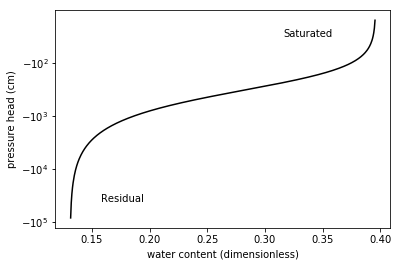

In [1367]:
# So how does water content vary as a function of pressure head?
# from van Genuchten (1980): dimensionless water content:

# take soil properties for a silt loam (van Genuchten 1980)
# theta is relative water content cm3/cm3 volume per total volume of soil
# i.e. at saturated porosity theta = 1 and wilting point theta = 0!

theta_s = 0.396 # cm3/cm3 saturated
theta_r = 0.131 # cm3/cm3 residual
Ks = 4.96 #(cm/day)
alpha = 4.23*10**(-3) #(1/cm)
n = 2.06
m = 1-1./n

# define the full range of theta values, cliipping the limits since they are unstable (resulting in div0)
theta = np.linspace(theta_r,theta_s,500)[1:-1]

# define a function to convert absolute theta values to relative theta values
def get_THETA(theta=theta):
    Theta = ((theta-theta_r)/(theta_s-theta_r))
    return Theta

# we'll define a function here so we can use it again later
def get_h(theta=theta):
    Theta = get_THETA(theta)
    h = -(1./alpha)*((Theta**(-1./m))-1)**(1/n)
    return h

h = get_h()

# plot the results
plt.figure(1)
plt.plot(theta, h, 'k-')
plt.yscale('symlog')
plt.xlabel('water content (dimensionless)')
plt.ylabel('pressure head (cm)')
plt.text(0.8*np.max(theta),2*np.max(h),'Saturated')
plt.text(1.2*np.min(theta),0.5*np.min(h),'Residual')
plt.show()

Next we need an expression that can relate the hydraulic conductivity to the water content. Hydraulic conductivity is greatest in saturated soils. van Genuchten (1980) has it tailing off as a power law.

$$
\begin{equation}
K_r=\theta^{1/2}\:\left[1-(1-\theta^{1/m})^m\right]^2 \tag{10} \label{eq:10}
\end{equation}
$$

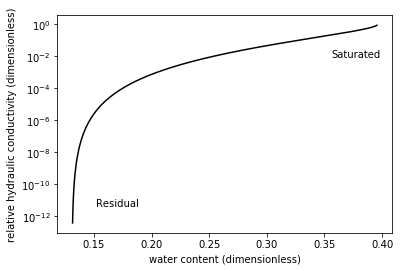

In [1368]:
#we'll define a function for K as a function of theta so we can call it again
def get_K(theta=theta):
    Theta = get_THETA(theta)
    K = (Theta**0.5)*(1-(1-Theta**(1./m))**m)**2.
    return K

Kr = get_K()

# plot the results
plt.semilogy(theta, Kr, 'k-')
plt.xlabel('water content (dimensionless)')
plt.ylabel('relative hydraulic conductivity (dimensionless)')
plt.text(np.max(theta)*0.9,0.01*np.max(Kr),'Saturated')
plt.text(np.min(theta)+0.02,10*np.min(Kr),'Residual')
plt.show()

So let's check our results against the analytical relationship between $K_r$ and $h$ derived by van Genuchten (1980):

$$
\begin{equation}
K_r(h)= {{\left\{ 1-\left( \alpha h\right)^{n-1} \left[1+\left( \alpha h\right)^n \right]^{-m}\right\}}^2\over{\left[ 1+\left( \alpha h \right)^n \right]^{m/2}}} \tag{11} \label{eq:11}
\end{equation}
$$

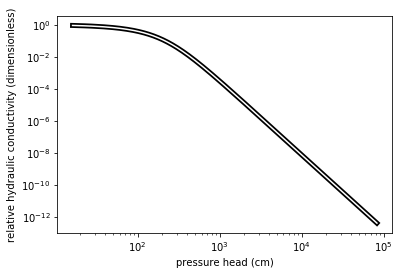

In [1369]:
Kr2 = (1-(alpha*-h)**(n-1)*(1+(alpha*-h)**n)**(-m))**2./(1+(alpha*-h)**n)**(m/2.)

plt.loglog(-h,Kr,'k-',lw=5)
plt.loglog(-h,Kr2,'w-')
plt.xlabel('pressure head (cm)')
plt.ylabel('relative hydraulic conductivity (dimensionless)')
plt.show()

The differential water capacity C(h) can be defined as the derivative of the soil water retention curve:

$$
\begin{equation}
C(h) = {{d\theta}\over{dh}} \tag{12} \label{eq:12}
\end{equation}
$$

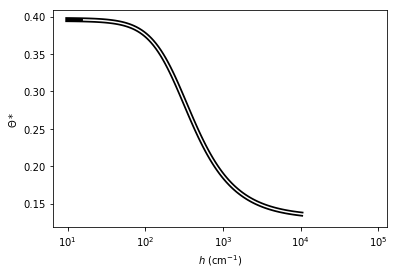

In [1370]:
# define a range of h values
h_test = np.logspace(1,4,100)
Theta_test = (1./(1+(alpha*h_test)**n))**m

def get_theta(Theta=Theta):
    theta = theta_r+Theta*(theta_s-theta_r)
    return theta

theta_test = get_theta(Theta_test)
plt.figure()
plt.subplot()
plt.plot(h_test,theta_test,'k-',lw=5)
plt.plot(-h,theta,'w-')
plt.xscale('symlog')
plt.xlabel('$h$ (cm$^{-1}$)')
plt.ylabel('$\Theta*$')

Given the relationship between $h$ and $\Theta$ described in equation 8, we can compute the derivative (thanks Mathematica!) with respect to $\Theta$ to get $dh/d\theta$ which we require to solve the Richards equation:

$$
\begin{equation}
{{dh}\over{d\theta}} = {{\left(\Theta^{-1/m}-1\right)^{1/n}}\over{\left(\theta_s-\theta_r\right)\alpha\:m\:n\:\Theta\left(\Theta^{1/m}-1\right) \tag{13} \label{eq:13}}}
\end{equation}
$$

Let's test this solution against a numerical approximation of $dh/d\theta$.

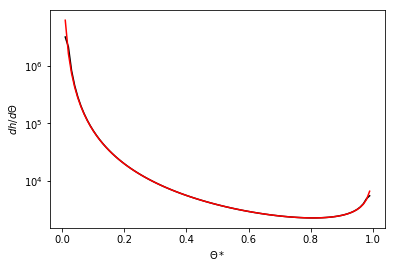

In [1384]:
# Diffusivity
theta = np.linspace(theta_r,theta_s, 100)[1:-1]
h = get_h(theta)
dh = np.gradient(h)
dtheta = np.gradient(theta)
Theta = get_THETA(theta)

#analytical solution for dhdtheta from mathematica
dhdtheta = -(Theta**(-1./m)-1.)**(1./n)/(alpha*m*n*Theta*(Theta**(1./m)-1.))*1./(theta_s-theta_r)
plt.plot(Theta,dh/dtheta,'k-')
plt.plot(Theta,dhdTheta,'r-')
plt.yscale('symlog')
plt.xlabel('$\Theta*$')
plt.ylabel('$dh/d\Theta$')

So now that we have everything we need to solve for the changing soil moisture content in our soil, it's time to set up the model run. First we will need to create some parameters to allow us to control the time over which the model will run for. Note that our hydraulic conductivity has units of cm/day so our modelled time is going to be in days

In [1069]:
# The model will start at time zero days
Time = 0 # in days
dt = 0.001 # length of one time step (in days)
EndTime = 10 # in days

Let's reset theta to be near zero (wilting point) throught the soil column so that the soil is effectively bone dry. Note that we need to track theta at each point in the soil column, so we will make it the same length vector as `z`

In [1070]:
# reset Theta
theta = np.zeros(len(z))+0.01

We'll also need to set an effective precipitation rate (cm/day) at which water is being delivered to the soil for potential infiltration

In [1639]:
Pe = 10. # preciptitation rate in cm/day

Now let's create an empty figure that we will update as the model run proceeds.

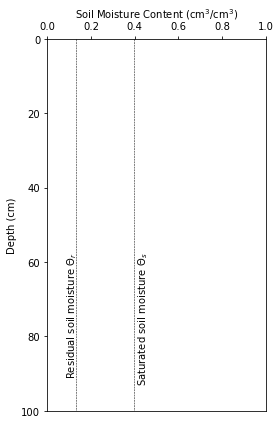

In [1640]:
# First set up the figure and add the axis
fig = plt.figure(1,figsize=(4,6))
ax = plt.subplot()

# Set the x axis limits, move labels to the top of the box and label
ax.set_xlim(0,1.)
ax.xaxis.tick_top()
ax.set_xlabel("Soil Moisture Content (cm$^3$/cm$^3$)")
ax.xaxis.set_label_position('top') 

# Set the y axis limits and invert the y axis
ax.set_ylim((np.min(z), np.max(z)))
ax.invert_yaxis()
ax.set_ylabel("Depth (cm)")

#plot min and max soil moisture content
plt.plot([theta_r,theta_r],[0,100],'k--',lw=0.5)
plt.text(theta_r-0.05,60,'Residual soil moisture $\Theta_r$',rotation=90)
plt.plot([theta_s,theta_s],[0,100],'k--',lw=0.5)
plt.text(theta_s+0.01,60,'Saturated soil moisture $\Theta_s$',rotation=90)
plt.tight_layout()

# Create an empty line object that we will populate repeatedly to create the animation
line, = ax.plot([], [], lw=2)

In [1641]:
# initialization function: plot the background of each frame and reset the line object to be empty
def init():
    line.set_data([], [])
    return (line,)

In [1642]:
# animation function. This is called sequentially
def animate(i):
    
    # declare the stuff we need from above as globals
    global Time, z, theta
    
    # increment time
    Time += dt
    
    # get pressure head and hydraulic conductivity
    K = Ks*get_K(theta)
    
    # get conductivity values at the flux points (cell boundaries) by interpolation to midpoints
    K = np.interp(np.arange(0.5,len(K)),np.arange(0.,len(K)),K)
    
    # calculate the diffusivity at the flux points (cell boundaries)
    Theta = get_THETA(theta)
    Theta = np.interp(np.arange(0.5,len(Theta)),np.arange(0.,len(Theta)),Theta)
    
    dhdtheta = (Theta**(-1./m)-1.)**(1./n)/(alpha*m*n*Theta*(Theta**(1./m)-1.))*1./(theta_s-theta_r)
    dhdtheta[Theta>0.8] = dhdtheta[np.argmin(np.abs(Theta-0.8))]
    D = K*dhdtheta
    
    #calculate the soil moisture gradient
    dthetadz = np.diff(theta,dz)
    dthetadz = np.append(dthetadz,dthetadz[-1])
    
    # calculate the downward fluxes
    q_out = (K+D*dthetadz)*dt
    q_in = np.roll(q_out,1)
    
    #fix the boundary conditions so constant water supply and free draining soil
    q_in[0] = Pe*dt
    q_out[-1] = q_in[-1]
    
    # limit downward flux to supply rate to handle condition when dhdtheta tends to infinite as
    # soil moisture content approaches saturation
    q_in = np.clip(q_in,0,q_in[0])    
    q_out = np.clip(q_out,0,q_in)
    
    # update theta
    theta += (q_in-q_out)/dz
    
    if (q_out[0] > q_in[0]):
        print(Time,q_in[0],q_out[0])
    
    #limit theta to max value 1. when fully saturated. Infiltration rate equals saturated soil conductivity from here on in
    theta = np.clip(theta,theta_r,theta_s)
    #theta_plot = theta_r+theta*(theta_s-theta_r)
    
    line.set_data(theta, z)
    return (line,)

In [1645]:
# reset theta
theta = np.zeros(len(z))+0.001*(np.max(z)-z)+theta_r + 0.001
#theta[0] = theta_s-0.001
dt = 0.0005

# call the animator. blit=True means only re-draw the parts that have changed.
NoFrames = int(np.ceil(EndTime/dt)) # number of frames in the animation
NoFrames = 1000
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=NoFrames, interval=1, blit=True)

In [1646]:
HTML(anim.to_html5_video())